<a href="https://colab.research.google.com/github/AprajitaChhawi/Customer_Sentiment_Analysis/blob/main/Customer_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install twython

In [7]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
import operator
import plotly.express as px

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv("McDonald_s_Reviews.csv.zip", encoding="latin-1")

In [11]:
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


<Axes: >

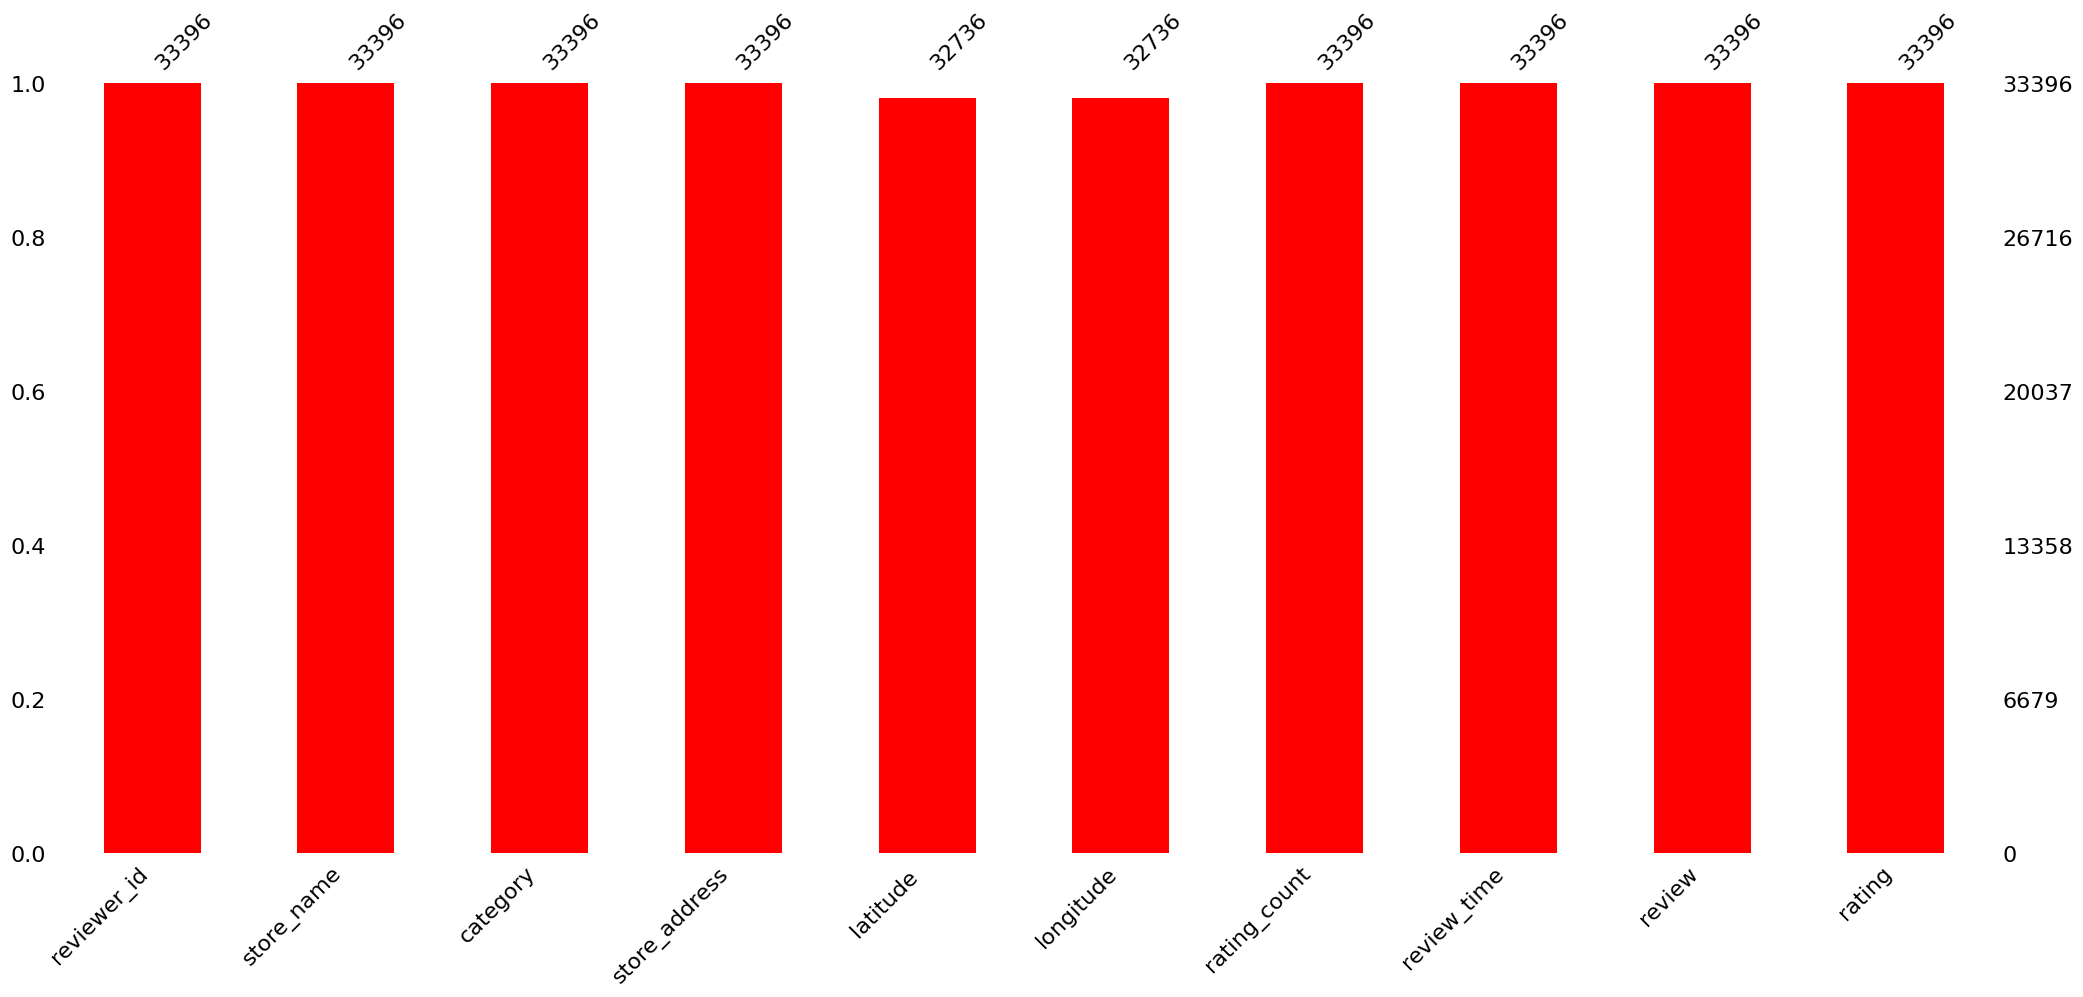

In [12]:
msno.bar(df, color = 'r')

In [13]:
def null_count():
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='turbo',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,reviewer_id,int64,0,0.000000
1,store_name,object,0,0.000000
2,category,object,0,0.000000
3,store_address,object,0,0.000000
4,latitude,float64,660,0.019763
5,longitude,float64,660,0.019763
6,rating_count,object,0,0.000000
7,review_time,object,0,0.000000
8,review,object,0,0.000000
9,rating,object,0,0.000000


In [14]:
df.duplicated().sum()

0

In [15]:
df.columns

Index(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ',
       'longitude', 'rating_count', 'review_time', 'review', 'rating'],
      dtype='object')

In [16]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

reviewer_id: 33396 distinct values
store_name: 2 distinct values
category: 1 distinct values
store_address: 40 distinct values
latitude : 40 distinct values
longitude: 40 distinct values
rating_count: 51 distinct values
review_time: 39 distinct values
review: 22285 distinct values
rating: 5 distinct values


In [17]:
df[df.isnull().any(axis = 1)]

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
22141,22142,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",3 months ago,Breakfast specials are good. The sausage burri...,4 stars
22142,22143,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",a year ago,This isn't your typical McDonald's. This place...,5 stars
22143,22144,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",2 weeks ago,This place was serving good quality breakfast ...,4 stars
22144,22145,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",a month ago,I understand this is a very busy location but ...,1 star
22145,22146,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",2 months ago,"When I arrived at McDonald's, it was very crow...",4 stars
...,...,...,...,...,...,...,...,...,...,...
27719,27720,ýýýMcDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",3 years ago,This McDonald's is across the street from Waik...,5 stars
27720,27721,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",11 months ago,"Seems like, they always makes some mistakes wh...",2 stars
27721,27722,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",11 months ago,Convenient to the east end of Kalakaua Ave. Lo...,4 stars
27722,27723,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",11 months ago,"Lost McDonald's in Honolulu, if you can avoid ...",1 star


In [18]:
df = df.dropna()

In [19]:
df1 = df.copy()

In [20]:
df1.head(2)

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars


In [21]:
df1[['store_address']].sample(5)

,store_address
19009,"1100 N US Hwy 377, Roanoke, TX 76262, United S..."
578,"13749 US-183 Hwy, Austin, TX 78750, United States"
2862,"72-69 Kissena Blvd, Queens, NY 11367, United S..."
32897,"3501 Biscayne Blvd, Miami, FL 33137, United St..."
19802,"621 Broadway, Newark, NJ 07104, United States"


In [22]:
df1[['City', 'State']] = df1['store_address'].apply(lambda x: pd.Series(x.split(', ')[-3:-1]))

In [23]:
df1[['City','State']].sample(5)

,City,State
27483,Roanoke,TX 76262
9507,Washington,DC 20036
31599,Dallas,TX 75203
9474,Washington,DC 20036
32126,Dallas,TX 75203


In [24]:
df1 = df1.drop(columns=['store_address'])

In [25]:
df1[['review_time']].sample(5)

,review_time
14097,2 years ago
24732,11 months ago
31861,2 years ago
10146,3 months ago
25429,6 years ago


In [26]:
df1[['rating']].sample(5)

,rating
3165,4 stars
16932,5 stars
6568,3 stars
1630,5 stars
26848,5 stars


In [27]:
df1.insert(5, "Star", df1["rating"].str.split(" ").str[0])

In [28]:
df1[['Star']].sample(5)

,Star
23631,1
4531,1
3722,3
30578,4
18193,5


In [29]:
df1 = df1.drop(columns=['rating'])

In [30]:
unique_review = df1['review'].unique()
unique_review

array(['Why does it look like someone spit on my food?\nI had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.',
       "It'd McDonalds. It is what it is as far as the food and atmosphere go. The staff here does make a difference. They are all friendly, accommodating and always smiling. Makes for a more pleasant experience than many other fast food places.",
       'Made a mobile order got to the speaker and checked it in.\nLine was not moving so I had to leave otherwise Iï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½d be late for work.\nNever got the refund in the app.\nI called them and they said I could only get my money back in person because it was stuck in the system.\nWent there in person the next day  and the manager told me she wasnï¿',
       ..., 'To remove hunger is enough',
       "I

In [31]:
def clean_review(review):
    review = review.lower()
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = re.sub(r'\s+', ' ', review).strip()

    stop_words = set(stopwords.words('english'))
    review_tokens = nltk.word_tokenize(review)
    review = ' '.join([word for word in review_tokens if word not in stop_words])


    return review

df1['clean_reviews'] = df1['review'].apply(clean_review)

print(df1[['clean_reviews']])

                                           clean_reviews
0      look like someone spit food normal transaction...
1      itd mcdonalds far food atmosphere go staff mak...
2      made mobile order got speaker checked line mov...
3      mc crispy chicken sandwich customer service qu...
4      repeat order times drive thru still manage mes...
...                                                  ...
33391                                      treated badly
33392                                       service good
33393                               remove hunger enough
33394                       good lately become expensive
33395                                     took good care

[32736 rows x 1 columns]


In [32]:
df1 = df1.drop(columns=['review'])

In [33]:
!pip install colorama
import colorama
from colorama import Fore
specified_columns = ['City', 'State', 'review_time', 'Star']

for col in specified_columns:
    total_unique_values = df1[col].nunique()
    print(f'Total unique values for {col}: {total_unique_values}')

    top_values = df1[col].value_counts()

    colors = [Fore.RED, Fore.GREEN, Fore.YELLOW, Fore.BLUE, Fore.MAGENTA, Fore.CYAN, Fore.WHITE, Fore.LIGHTBLACK_EX, Fore.LIGHTRED_EX, Fore.LIGHTGREEN_EX]

    for i, (value, count) in enumerate(top_values.items()):
        color = colors[i % len(colors)]
        print(f'{color}{value}: {count}{Fore.RESET}')

    print('\n' + '=' * 30 + '\n')

Total unique values for City: 26
New York: 3486
Orlando: 3090
Austin: 1726
Kissimmee: 1720
North Hollywood: 1710
Fern Park: 1700
Dallas: 1650
Miami: 1570
Newark: 1290
San Diego: 1230
Roanoke: 1168
Queens: 1140
Los Angeles: 1034
Las Vegas: 1030
Brodheadsville: 1028
Voorhees Township: 943
Salt Lake City: 890
Fort Worth: 850
Santa Monica: 820
Sunnyvale: 800
Oak Park: 751
Washington: 683
San Antonio: 635
Champlain: 620
Annandale: 602
Miami Beach: 570


Total unique values for State: 36
FL 32819: 2380
NY 10001: 2070
FL 34746: 1720
CA 91602: 1710
FL 32730: 1700
TX 75203: 1650
FL 33137: 1570
NJ 07104: 1290
TX 76262: 1168
NY 11367: 1140
NY 10003: 1140
NV 89119: 1030
PA 18322: 1028
NJ 08043: 943
TX 78724: 926
UT 84106: 890
TX 76177: 850
CA 90405: 820
TX 78750: 800
CA 94086: 800
IL 60302: 751
FL 32837: 710
DC 20036: 680
CA 92109: 680
TX 78257: 635
NY 12919: 620
VA 22003: 602
FL 33139: 570
CA 90021: 550
CA 92111: 550
CA 90044: 481
NY 10013: 270
NY 10002: 3
CA 90025: 3
DC 20004: 3
NY 10038: 3


To

In [34]:
df2 = df1.copy()

In [35]:
df2.head(2)

,reviewer_id,store_name,category,latitude,longitude,Star,rating_count,review_time,City,State,clean_reviews
0,1,McDonald's,Fast food restaurant,30.460718,-97.792874,1,"1,240",3 months ago,Austin,TX 78750,look like someone spit food normal transaction...
1,2,McDonald's,Fast food restaurant,30.460718,-97.792874,4,"1,240",5 days ago,Austin,TX 78750,itd mcdonalds far food atmosphere go staff mak...


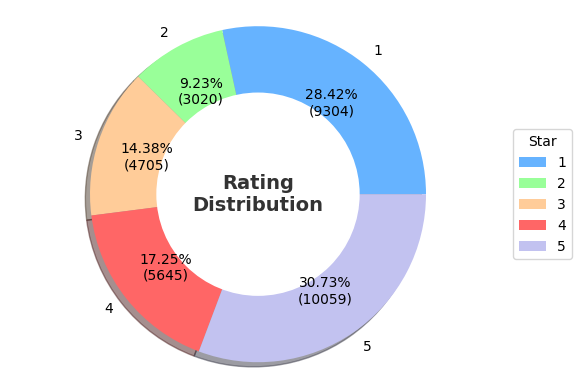

In [36]:
unique_star = df1['Star'].unique()

explode = [0] * len(unique_star)

sentiment_counts = df2.groupby("Star").size()

colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff6666', '#c2c2f0']

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts,
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})',
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="black"),
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True
)
center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Rating\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Star", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')

plt.show()

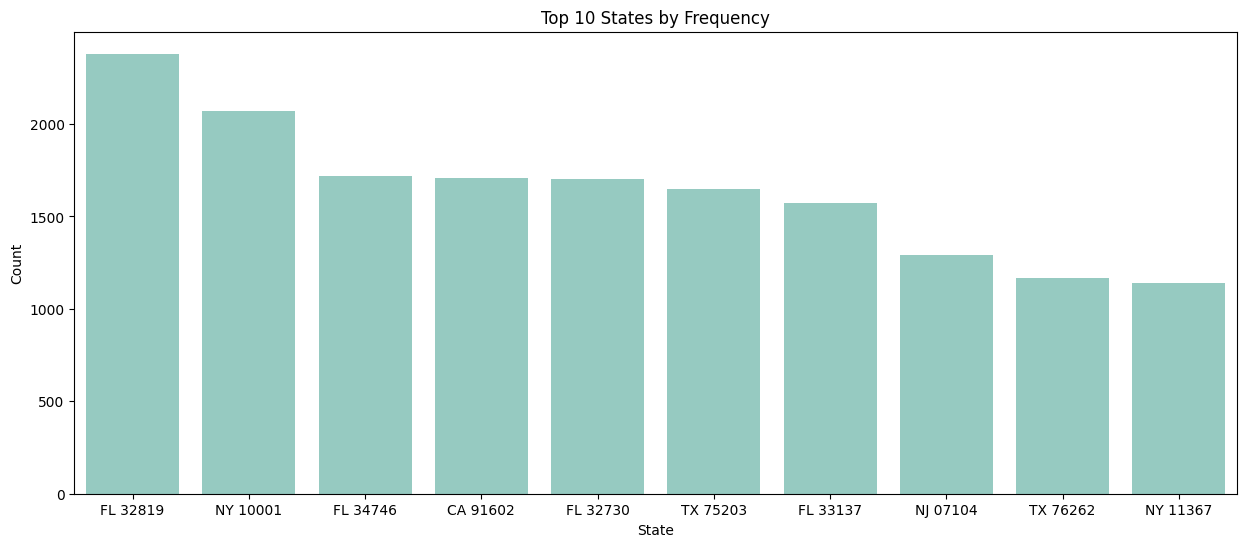

In [37]:
top_10_states = df2['State'].value_counts().nlargest(10)

plt.figure(figsize=(15, 6))
sns.set_palette("Set3")
sns.countplot(x='State', data=df2, order=top_10_states.index)
plt.title('Top 10 States by Frequency')
plt.xlabel('State')
plt.ylabel('Count')
plt.show()

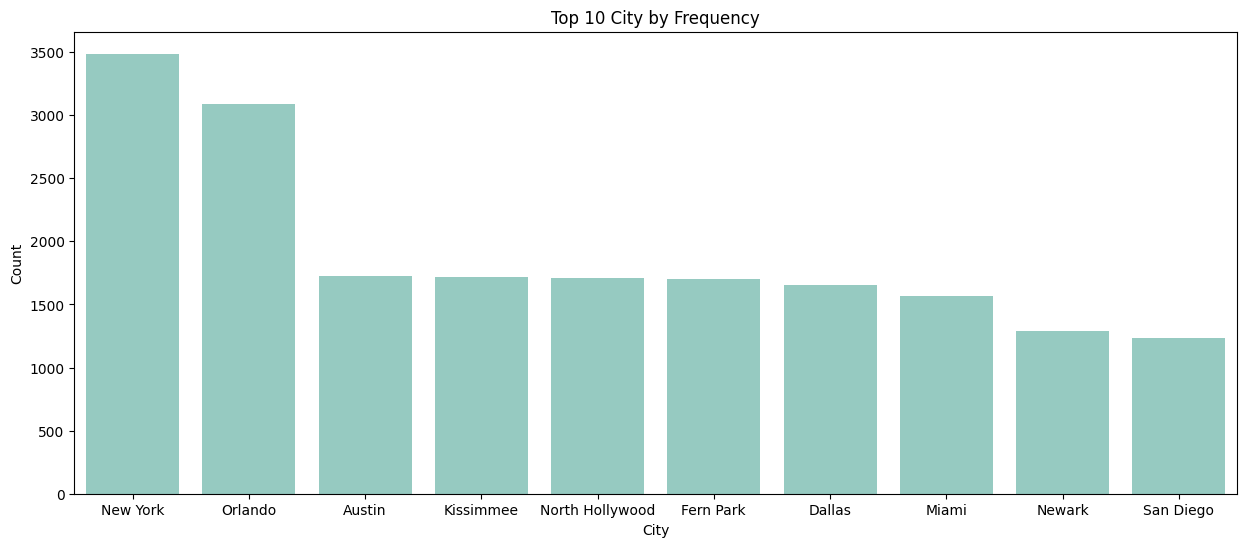

In [38]:
top_10_city = df2['City'].value_counts().nlargest(10)

plt.figure(figsize=(15, 6))
sns.set_palette("Set3")
sns.countplot(x='City', data=df2, order=top_10_city.index)
plt.title('Top 10 City by Frequency')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()

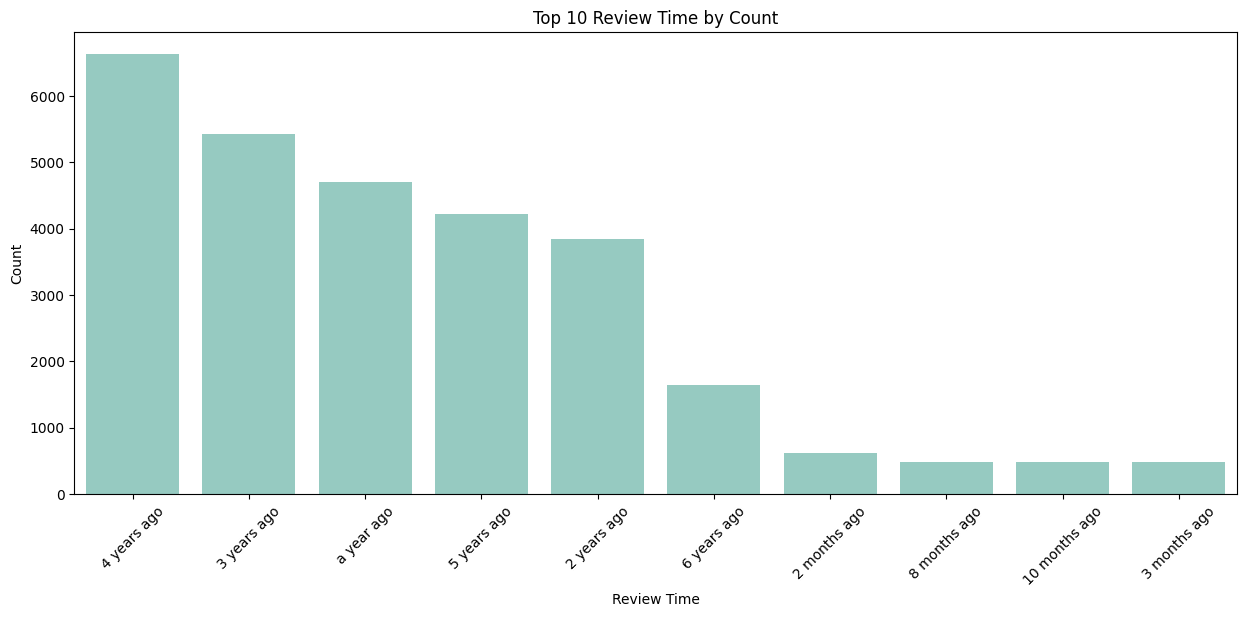

In [39]:
plt.figure(figsize=(15, 6))
sns.set_palette("Set3")
sns.countplot(x='review_time', data=df2, order=df2['review_time'].value_counts().iloc[:10].index)
plt.title('Top 10 Review Time by Count')
plt.xlabel('Review Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

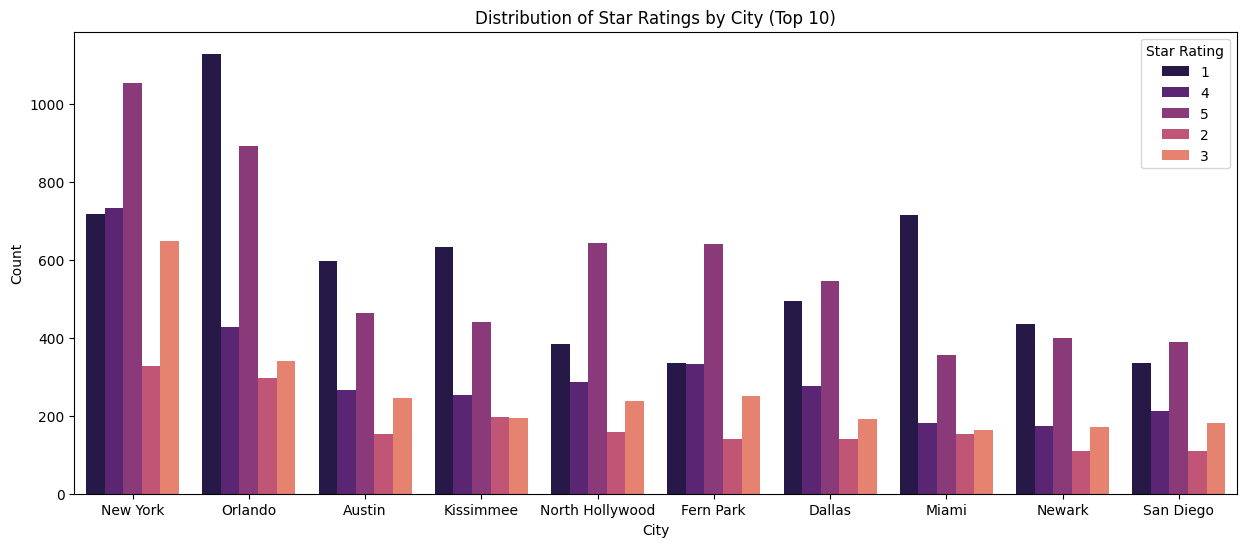

In [40]:
plt.figure(figsize=(15, 6))
sns.set_palette("magma")
sns.countplot(x='City', hue='Star', data=df2, order=df2['City'].value_counts().iloc[:10].index)
plt.title('Distribution of Star Ratings by City (Top 10)')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Star Rating')
plt.show()

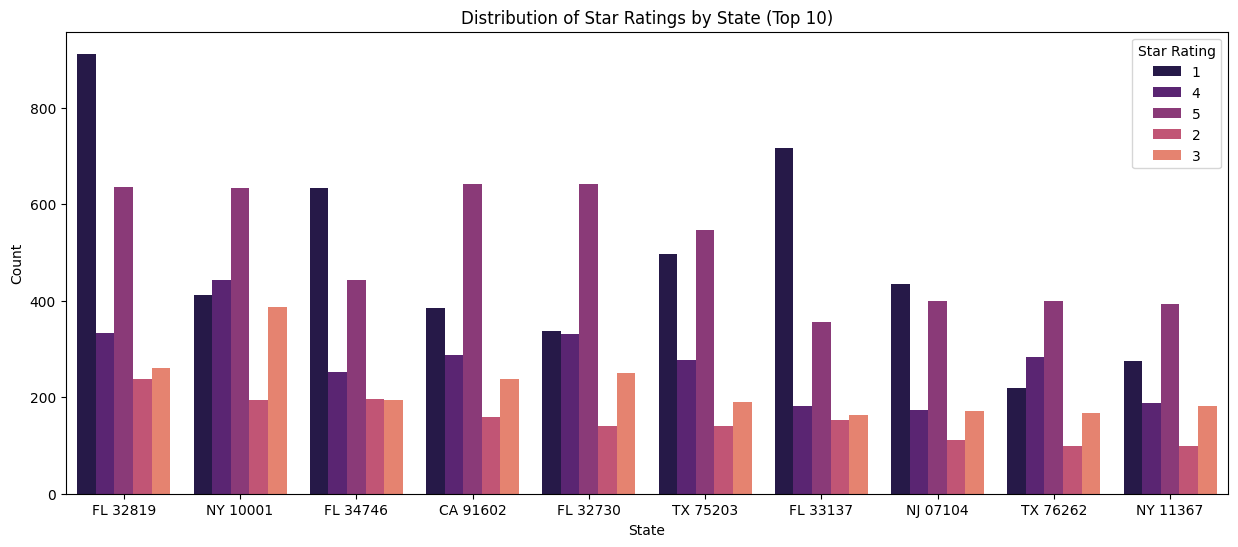

In [41]:
plt.figure(figsize=(15, 6))
sns.set_palette("magma")
sns.countplot(x='State', hue='Star', data=df2, order=df2['State'].value_counts().iloc[:10].index)
plt.title('Distribution of Star Ratings by State (Top 10)')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Star Rating')
plt.show()

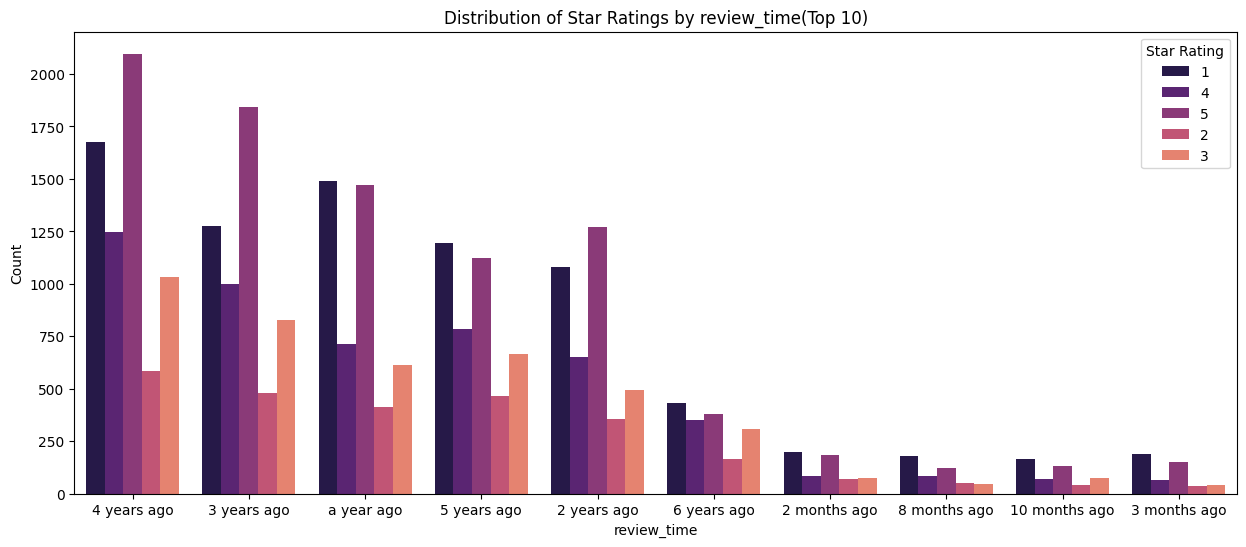

In [42]:
plt.figure(figsize=(15, 6))
sns.set_palette("magma")
sns.countplot(x='review_time', hue='Star', data=df2, order=df2['review_time'].value_counts().iloc[:10].index)
plt.title('Distribution of Star Ratings by review_time(Top 10)')
plt.xlabel('review_time')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Star Rating')
plt.show()

In [43]:
df3 = df2.copy()

In [44]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32736 entries, 0 to 33395
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    32736 non-null  int64  
 1   store_name     32736 non-null  object 
 2   category       32736 non-null  object 
 3   latitude       32736 non-null  float64
 4   longitude      32736 non-null  float64
 5   Star           32736 non-null  object 
 6   rating_count   32736 non-null  object 
 7   review_time    32736 non-null  object 
 8   City           32736 non-null  object 
 9   State          32736 non-null  object 
 10  clean_reviews  32736 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 3.0+ MB


In [45]:
df3 = df3[["Star","clean_reviews"]]
df3.head(2)

,Star,clean_reviews
0,1,look like someone spit food normal transaction...
1,4,itd mcdonalds far food atmosphere go staff mak...


In [46]:
analyzer = SentimentIntensityAnalyzer()

df3['sentiment_score'] = df3['clean_reviews'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df3['sentiment'] = df3['sentiment_score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df3[['clean_reviews', 'sentiment_score', 'sentiment']].head())

                                       clean_reviews  sentiment_score  \
0  look like someone spit food normal transaction...           0.5541   
1  itd mcdonalds far food atmosphere go staff mak...           0.8591   
2  made mobile order got speaker checked line mov...          -0.2960   
3  mc crispy chicken sandwich customer service qu...           0.0000   
4  repeat order times drive thru still manage mes...          -0.7184   

  sentiment  
0  positive  
1  positive  
2  negative  
3   neutral  
4  negative  


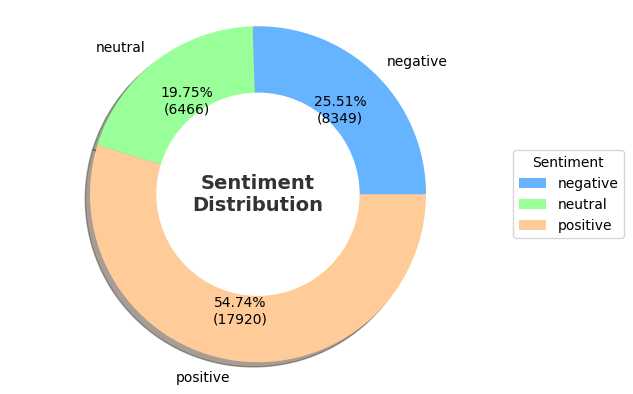

In [47]:
colors = ['#66b3ff', '#99ff99', '#ffcc99']

explode = (0.0, 0, 0)

sentiment_counts = df3.groupby("sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts,
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})',
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="black"),
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)
ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')

plt.show()

In [48]:
df3["word_count"] = df3['clean_reviews'].str.len()

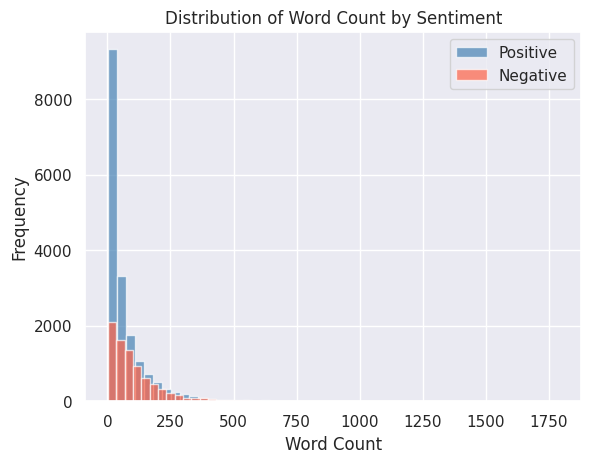

In [49]:
sns.set(style="darkgrid", palette="muted", color_codes=True)

positive_reviews = df3[df3["sentiment"] == 'positive']
negative_reviews = df3[df3["sentiment"] == 'negative']

sns.distplot(positive_reviews['word_count'], color='steelblue', label='Positive', kde=False, hist_kws={'alpha': 0.7})
sns.distplot(negative_reviews['word_count'], color='tomato', label='Negative', kde=False, hist_kws={'alpha': 0.7})

plt.title('Distribution of Word Count by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [50]:
df3['temp_list'] = df3['clean_reviews'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df3['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')

,Common_words,count
0,food,7616
1,service,6067
2,order,6030
3,mcdonalds,5977
4,good,5462
5,place,3298
6,get,3248
7,drive,2825
8,one,2657
9,fast,2622


In [51]:
df3['temp_list'] = df3['clean_reviews'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df3['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

fig = px.bar(top_words_df,
            x="count",
            y="Common_words",
            title='Common Words in Text Data',
            orientation='h',
            width=700,
            height=700,
            color='Common_words')

fig.show()

In [52]:
Positive_sent = df3[df3['sentiment'] == 'positive']
Negative_sent = df3[df3['sentiment'] == 'negative']
Neutral_sent = df3[df3['sentiment'] == 'neutral']

In [53]:
top = Counter([item for sublist in df3[df3['sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,5071
1,food,4409
2,service,3388
3,mcdonalds,3349
4,excellent,2518
5,order,2448
6,great,2169
7,place,2008
8,clean,1795
9,fast,1770


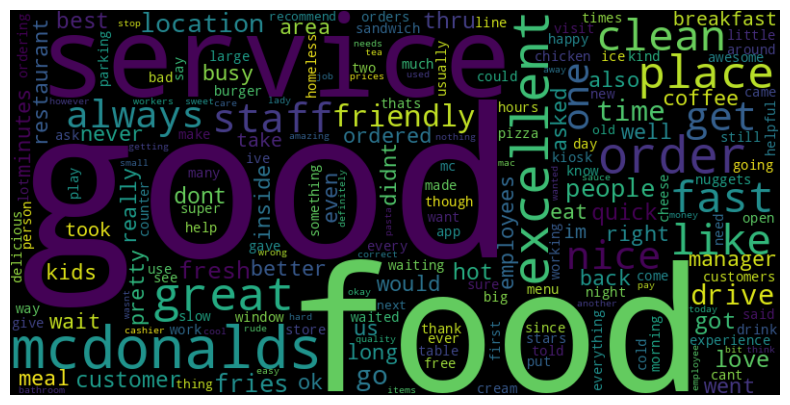

In [54]:
top = Counter([item for sublist in df3[df3['sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(), columns=['Common_words', 'count'])

wordcloud_data = temp_neutral.set_index('Common_words')['count'].to_dict()

wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(wordcloud_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [55]:
top = Counter([item for sublist in df3[df3['sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Blues')

,Common_words,count
0,neutral,942
1,food,845
2,mcdonalds,764
3,order,677
4,service,629
5,fast,552
6,drive,518
7,get,403
8,slow,381
9,thru,348


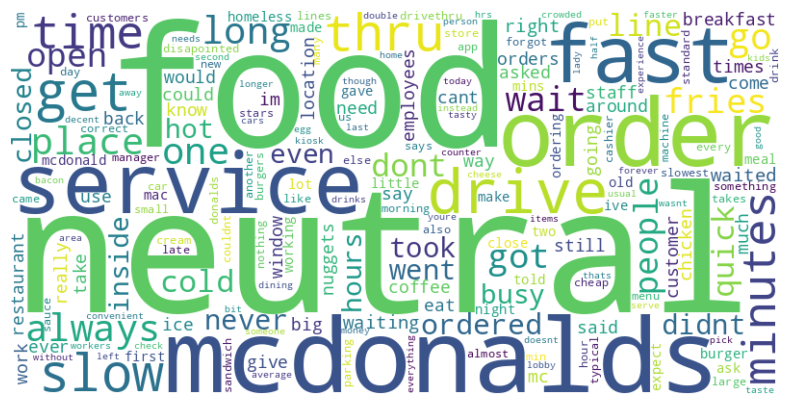

In [56]:
top = Counter([item for sublist in df3[df3['sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(), columns=['Common_words', 'count'])

# Create a wordcloud_data dictionary
wordcloud_data = temp_neutral.set_index('Common_words')['count'].to_dict()

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [57]:
top = Counter([item for sublist in df3[df3['sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')

,Common_words,count
0,order,2905
1,food,2362
2,service,2050
3,mcdonalds,1864
4,get,1334
5,drive,1131
6,worst,1088
7,one,1071
8,bad,1059
9,rude,1056


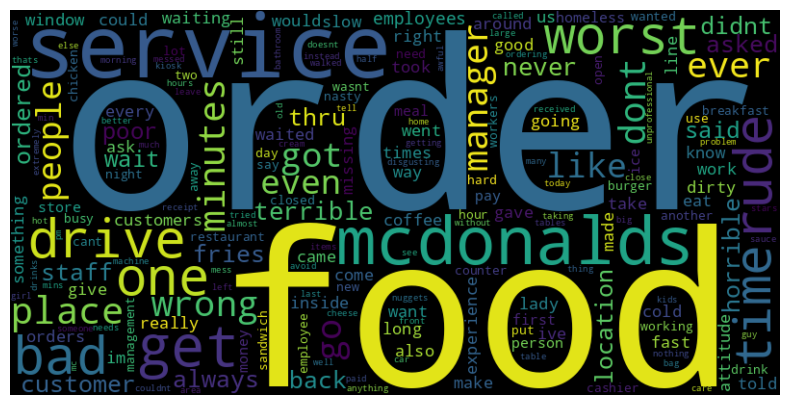

In [58]:
top = Counter([item for sublist in df3[df3['sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(), columns=['Common_words', 'count'])

wordcloud_data = temp_negative.set_index('Common_words')['count'].to_dict()

wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(wordcloud_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

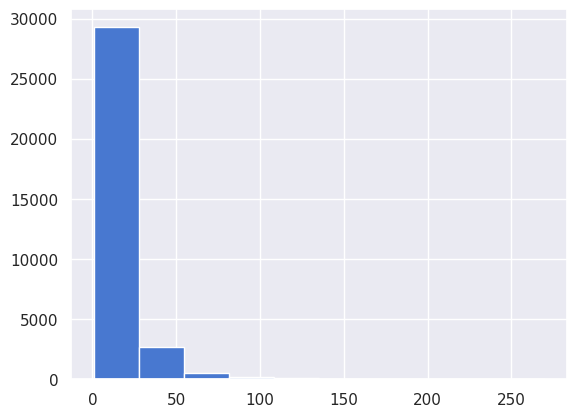

In [59]:
df4 = df3.copy()
X = df4['clean_reviews']
y = df4['sentiment']
text_lengths = X.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
nb_pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
svc_pipeline = make_pipeline(TfidfVectorizer(), SVC())
pa_pipeline = make_pipeline(TfidfVectorizer(), PassiveAggressiveClassifier())

In [62]:
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [63]:
nb_predictions = nb_pipeline.predict(X_test)

In [64]:
print("Multinomial Naive Bayes Classifier:")
print(classification_report(y_test, nb_predictions))

Multinomial Naive Bayes Classifier:
              precision    recall  f1-score   support

    negative       0.83      0.75      0.79      1721
     neutral       0.98      0.22      0.37      1244
    positive       0.73      0.96      0.83      3583

    accuracy                           0.77      6548
   macro avg       0.85      0.65      0.66      6548
weighted avg       0.81      0.77      0.73      6548



In [65]:
pa_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('passiveaggressiveclassifier', PassiveAggressiveClassifier())])

In [66]:
pa_predictions = pa_pipeline.predict(X_test)

In [67]:
print("Passive Aggressive Classifier:")
print(classification_report(y_test, pa_predictions))

Passive Aggressive Classifier:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      1721
     neutral       0.89      0.91      0.90      1244
    positive       0.94      0.95      0.94      3583

    accuracy                           0.92      6548
   macro avg       0.91      0.91      0.91      6548
weighted avg       0.92      0.92      0.92      6548



In [68]:
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())])

In [69]:
svc_predictions = svc_pipeline.predict(X_test)

In [70]:
print("Support Vector Classifier:")
print(classification_report(y_test, svc_predictions))

Support Vector Classifier:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      1721
     neutral       0.91      0.91      0.91      1244
    positive       0.95      0.96      0.95      3583

    accuracy                           0.93      6548
   macro avg       0.92      0.92      0.92      6548
weighted avg       0.93      0.93      0.93      6548



In [71]:
from sklearn.metrics import confusion_matrix

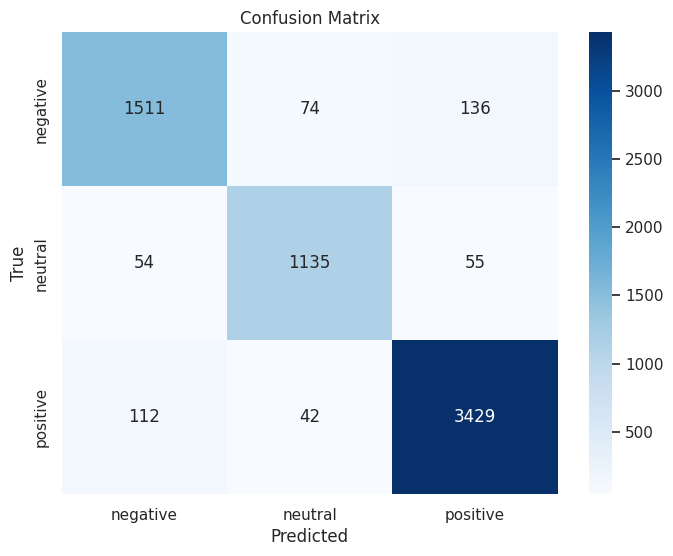

In [72]:
conf_mat = confusion_matrix(y_test, svc_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [73]:
svc_pipeline = make_pipeline(TfidfVectorizer(), SVC())
cv_scores = cross_val_score(svc_pipeline, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.91504391 0.91618939 0.9163803  0.91674623 0.91674623]
Mean CV score: 0.9162212100976523
